<a href="https://colab.research.google.com/github/Satomiko/20Newsgroups/blob/main/20Newsgroups_AllClasses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install nltk

In [2]:
pip install wordcloud matplotlib

In [120]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import LancasterStemmer
from nltk.stem import PorterStemmer
import string
from wordcloud import WordCloud, STOPWORDS
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB #for multinomialNB
from sklearn.metrics import accuracy_score, classification_report #for evaluation report
from collections import Counter


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
#after the review of text preprocessing method in "2. preprocessing methods.ipybb", the following function was created for text preprocessing.
#Datasets used in this project are cleaned using this function.

def preprocess_text(df, column_name):
    # Lowercasing
    df[column_name] = df[column_name].apply(lambda tokens: [token.lower() for token in tokens])

    # Stop Word Removal
    stop_words = set(stopwords.words('english'))
    df[column_name] = df[column_name].apply(lambda tokens: [word for word in tokens if word not in stop_words])

    # Removing one-letter words
    df[column_name] = df[column_name].apply(lambda tokens: [word for word in tokens if len(word) > 1])

    # Remove special symbols and punctuation
    df[column_name] = df[column_name].apply(lambda tokens: [word for word in tokens if word.isalpha()])

    # Lemmatizing
    lemmatizer = WordNetLemmatizer()
    df[column_name] = df[column_name].apply(lambda tokens: [lemmatizer.lemmatize(word) for word in tokens])

In [33]:
#creating function to count word a colomun

def word_count (df,colomun_name):
  df['word_count'] = df [colomun_name].apply(len)
  average_word_count = df['word_count'].mean()
  max_word_count = df['word_count'].max()
  minimum_word_count = df['word_count'].min()
  print(f"Average Word Count :{average_word_count}")
  print(f"Maximum Word Count :{max_word_count}")
  print(f"Minimum Word Count :{minimum_word_count}")


In [105]:
#use "fetch_20newsgroups" function from sklean.datasets  to load 20 newsgroups dataset
# removing "headers", "footers" and "quotes" is recommended because it is more realistic (https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html)
# loading dataset with or without "headers", "footers" and "quotes" and review each datasets.

remove = ("headers", "footers", "quotes")
news20group_train = fetch_20newsgroups(subset='train', remove = remove)
news20group_test = fetch_20newsgroups (subset='test', remove= remove)

In [9]:
#print list of 20 news groups
categories = news20group_train.target_names
categories

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [83]:
type(categories)

list

In [10]:
#number of observation in train data
len(news20group_train.data)

11314

In [11]:
#number of observation in test data
len(news20group_test.data)

7532

In [12]:
#count observation in each category (Train Data)

cat,frequency_train = np.unique(news20group_train.target, return_counts = True)
cat,frequency_train

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 array([480, 584, 591, 590, 578, 593, 585, 594, 598, 597, 600, 595, 591,
        594, 593, 599, 546, 564, 465, 377]))

In [13]:
#count observation in each category (Test Data)

cat,frequency_test = np.unique(news20group_test.target, return_counts = True)
cat,frequency_test

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 array([319, 389, 394, 392, 385, 395, 390, 396, 398, 397, 399, 396, 393,
        396, 394, 398, 364, 376, 310, 251]))

In [17]:
cat =  np.array (news20group_test.target_names)

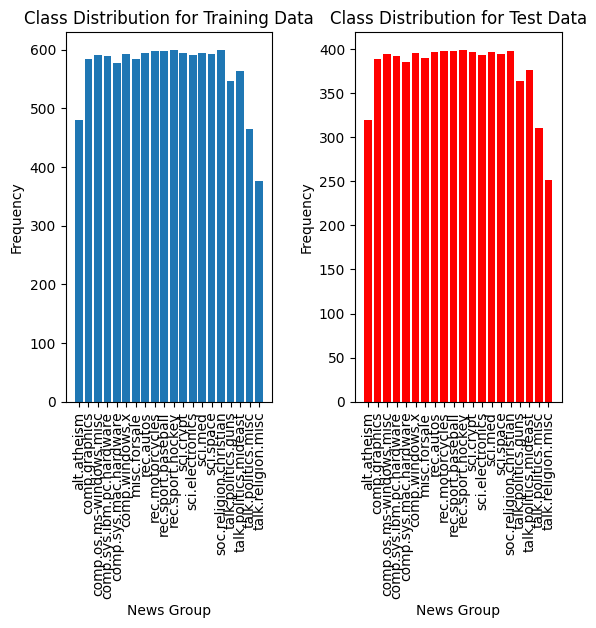

In [15]:
#create bar plots for both training data and test data to compare the distribution

#subplot 1 for training data distribution
plt.subplot(1,2,1) #1 row, 2 columns, position 1
plt.bar(cat, frequency_train)
plt.xticks(rotation=90)
plt.title('Class Distribution for Training Data')
plt.xlabel('News Group')
plt.ylabel('Frequency')

#subplot 2 for test data distribution
plt.subplot(1,2,2) #1 row, 2 columns, position 2
plt.bar(cat, frequency_test, color = 'red')
plt.xticks(rotation=90)
plt.title('Class Distribution for Test Data')
plt.xlabel('News Group')
plt.ylabel('Frequency')

plt.subplots_adjust(wspace=0.4) #increase horisontal space
plt.show()

In [129]:
#Convert Bunch format to dataframe
train_df = pd.DataFrame({'data': news20group_train.data, 'target': news20group_train.target})
test_df = pd.DataFrame({'data': news20group_test.data, 'target': news20group_test.target})


In [130]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11314 entries, 0 to 11313
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   data    11314 non-null  object
 1   target  11314 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 176.9+ KB


In [131]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7532 entries, 0 to 7531
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   data    7532 non-null   object
 1   target  7532 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 117.8+ KB


In [132]:
train_df.head()

,data,target
0,I was wondering if anyone out there could enli...,7
1,A fair number of brave souls who upgraded thei...,4
2,"well folks, my mac plus finally gave up the gh...",4
3,\nDo you have Weitek's address/phone number? ...,1
4,"From article <C5owCB.n3p@world.std.com>, by to...",14


In [133]:
#Tokenization
train_df ['data'] = train_df ['data'] .apply(word_tokenize)
test_df['data']= test_df ['data']. apply(word_tokenize)

In [134]:
#Word count for each document is added in the data.
print('[Train]')
word_count(train_df,'data')
print("[Test]")
word_count(test_df,'data')


[Train]
Average Word Count :270.4452890224501
Maximum Word Count :35955
Minimum Word Count :0
[Test]
Average Word Count :226.5367764206054
Maximum Word Count :78849
Minimum Word Count :0


In [52]:
#.info()shows there are no observation with empty data attribute, however the minimum word count shows zero.
#It indicates that there are empty or whitespace strings in the "data"column that are not very useful for the analysis.

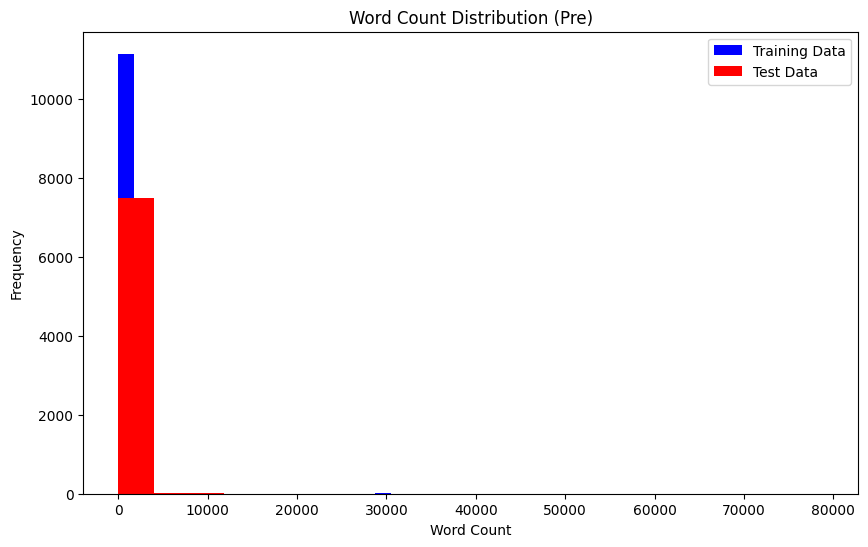

In [135]:
#word count distribution
# Create a histogram of word counts
plt.figure(figsize=(10, 6))  # Optional: set the figure size
plt.hist(train_df['word_count'], bins=20, color='blue', label='Training Data')
plt.hist(test_df['word_count'], bins=20, color='red', label='Test Data')

# Set labels for x and y axes
plt.xlabel("Word Count")
plt.ylabel("Frequency")

# Set the title of the histogram
plt.title("Word Count Distribution (Pre)")

# Add a legend
plt.legend(loc='upper right')

# Show the histogram
plt.show()

In [136]:
preprocess_text(train_df, 'data')
preprocess_text(test_df,'data')

In [137]:
# Remove rows with empty or whitespace strings in the "data" column
train_df = train_df[train_df['data'].apply(len) > 0]
test_df = test_df[test_df['data'].apply(len) > 0]

In [138]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10993 entries, 0 to 11313
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   data        10993 non-null  object
 1   target      10993 non-null  int64 
 2   word_count  10993 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 343.5+ KB


In [72]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7296 entries, 0 to 7531
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   data        7296 non-null   object
 1   target      7296 non-null   int64 
 2   word_count  7296 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 228.0+ KB


In [139]:
print('[Train]')
word_count(train_df,'data')
print("[Test]")
word_count(test_df,'data')

[Train]
Average Word Count :93.85927408350769
Maximum Word Count :6216
Minimum Word Count :1
[Test]
Average Word Count :88.28673245614036
Maximum Word Count :5058
Minimum Word Count :1


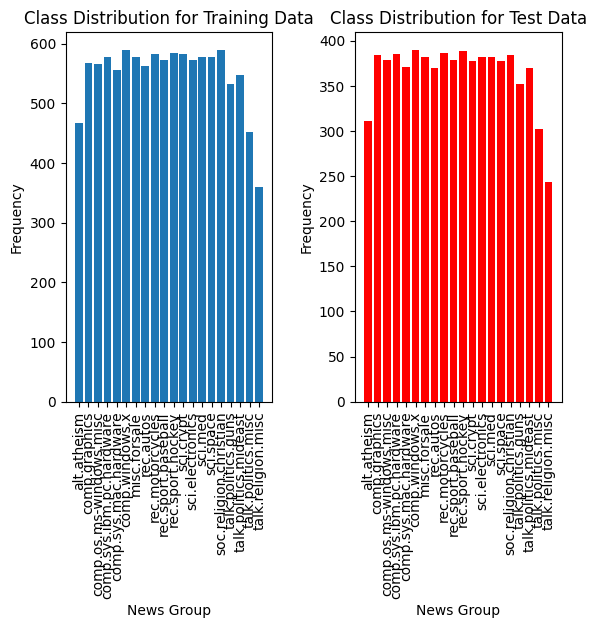

In [74]:
#create bar plots for both training data and test data to compare the distribution
frequency_train = train_df['target'].value_counts().sort_index()
frequency_test = test_df['target'].value_counts().sort_index()

category_label = [categories [i] for i in frequency_train.index]

#subplot 1 for training data distribution
plt.subplot(1,2,1) #1 row, 2 columns, position 1
plt.bar(category_label, frequency_train.values)
plt.xticks(rotation=90)
plt.title('Class Distribution for Training Data')
plt.xlabel('News Group')
plt.ylabel('Frequency')

#subplot 2 for test data distribution
plt.subplot(1,2,2) #1 row, 2 columns, position 2
plt.bar(category_label, frequency_test.values, color = 'red')
plt.xticks(rotation=90)
plt.title('Class Distribution for Test Data')
plt.xlabel('News Group')
plt.ylabel('Frequency')

plt.subplots_adjust(wspace=0.4) #increase horisontal space
plt.show()

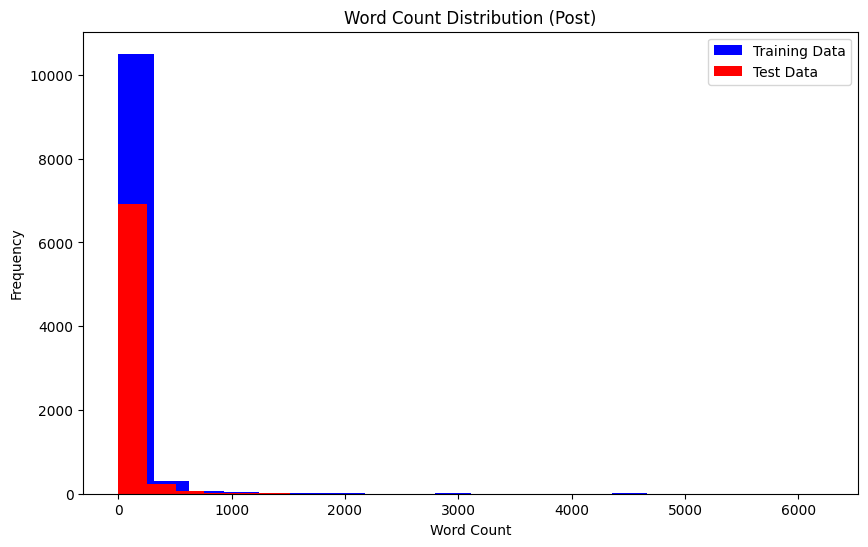

In [76]:
#word count distribution
# Create a histogram of word counts
plt.figure(figsize=(10, 6))  # Optional: set the figure size
plt.hist(train_df['word_count'], bins=20, color='blue', label='Training Data')
plt.hist(test_df['word_count'], bins=20, color='red', label='Test Data')

# Set labels for x and y axes
plt.xlabel("Word Count")
plt.ylabel("Frequency")

# Set the title of the histogram
plt.title("Word Count Distribution (Post)")

# Add a legend
plt.legend(loc='upper right')

# Show the histogram
plt.show()

In [77]:
test_df.head()

,data,target,word_count
0,"[little, confused, model, bonnevilles, heard, ...",7,41
1,"[familiar, format, thingies, seeing, folk, hea...",5,39
2,"[word, yes]",0,2
3,"[attacking, iraqi, drive, kuwait, country, who...",17,317
4,"[spent, two, solid, month, arguing, thing, obj...",19,10


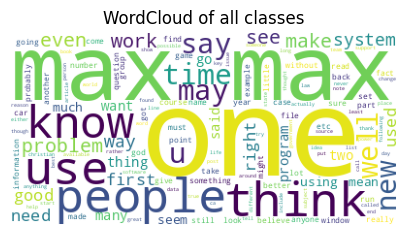

In [140]:
# plot word count for the dataset without grouping by classes
combined_text = " ".join(train_df['data'].apply(lambda x: ' '.join(x)))
wordcloud = WordCloud(background_color='white', max_words=200).generate(combined_text)
fig = plt.figure(figsize=[5,5])
plt.title('WordCloud of all classes')
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

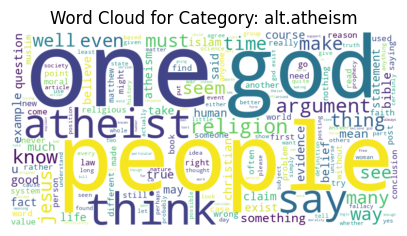

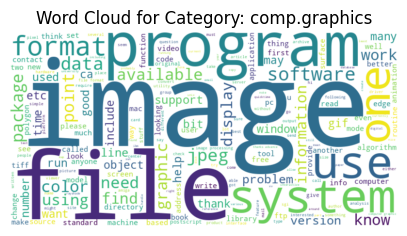

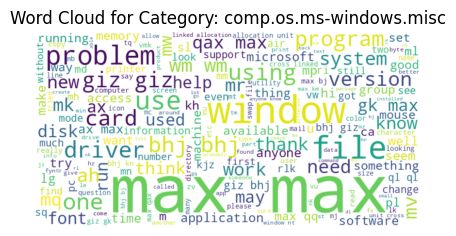

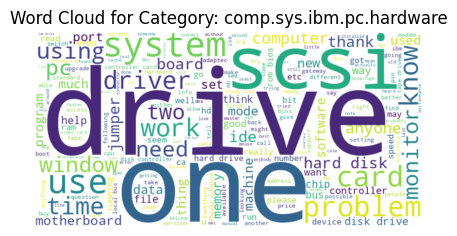

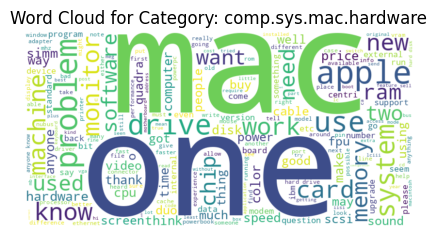

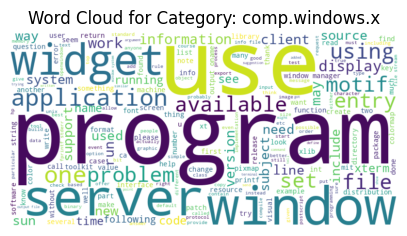

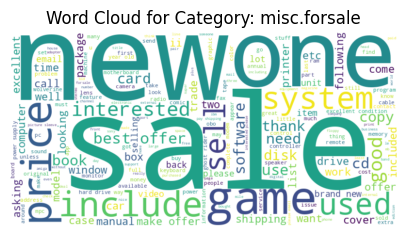

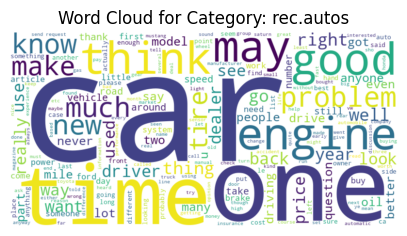

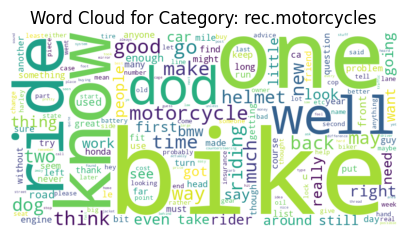

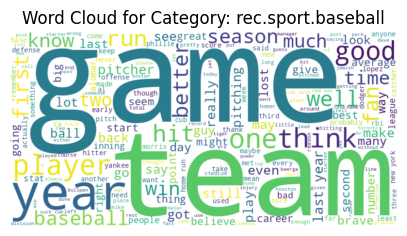

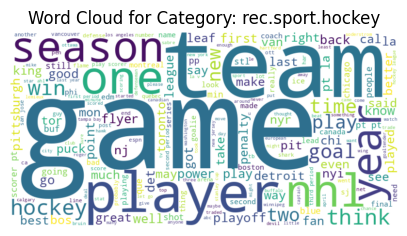

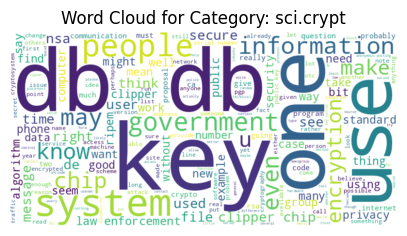

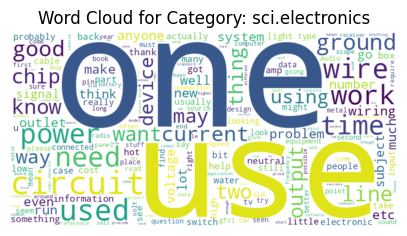

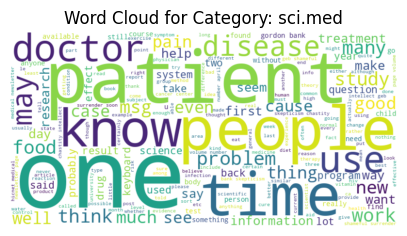

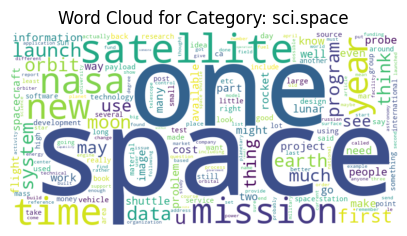

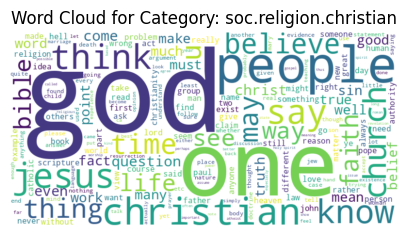

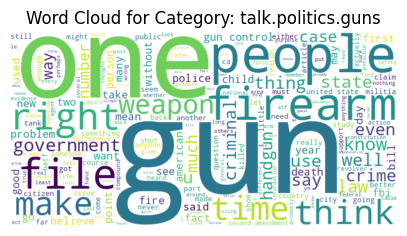

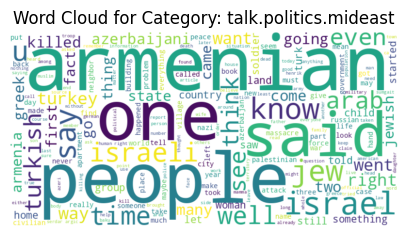

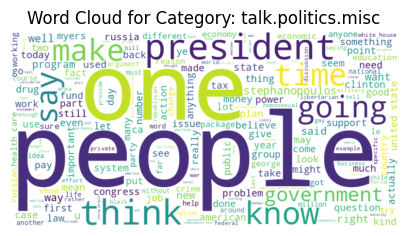

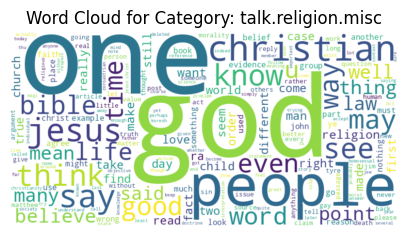

In [84]:
group_train_df = train_df.groupby('target')

# Create a word cloud for each target
for target, group in group_train_df:
    # Combine the text data from the group into a single string
    combined_text = " ".join(group['data'].apply(lambda x: ' '.join(x)))

    # Generate a word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)

    # Display the word cloud with the target as the title
    target_name= categories[target]
    plt.figure(figsize=(5, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Word Cloud for Category: {target_name}")
    plt.axis("off")
    plt.show()

In [122]:
# Group the training data by category
grouped_data = train_df.groupby('target')
# Create a dictionary to store the most frequent words for each category
most_frequent_words_by_category = {}

for category, data_group in grouped_data:
    # Concatenate the text data within the category into a single string
    text_for_category = ' '.join(data_group['data'])

    # Tokenize the text and count word frequencies
    tokens = text_for_category.split()
    word_frequencies = Counter(tokens)

    # Get the 10 most frequent words for the category
    most_common_words = word_frequencies.most_common(10)

    # Store the most frequent words in the dictionary
    most_frequent_words_by_category[category] = most_common_words

# Print the most frequent words for each category
for category, frequent_words in most_frequent_words_by_category.items():
    category_name = categories[category]
    print(f"Most frequent words in category {category_name}:")
    for word, count in frequent_words:
        print(f"{word}: {count}")
    print()

Most frequent words in category alt.atheism:
god: 442
one: 426
people: 331
would: 323
atheist: 256
think: 228
say: 216
argument: 193
religion: 182
thing: 179

Most frequent words in category comp.graphics:
image: 671
file: 471
program: 292
graphic: 285
format: 248
jpeg: 234
also: 232
would: 228
use: 222
system: 218

Most frequent words in category comp.os.ms-windows.misc:
max: 4449
window: 644
bhj: 452
file: 425
giz: 422
wm: 254
problem: 237
use: 225
ah: 219
driver: 214

Most frequent words in category comp.sys.ibm.pc.hardware:
drive: 726
card: 352
system: 290
disk: 286
one: 273
scsi: 259
controller: 256
would: 243
problem: 218
use: 216

Most frequent words in category comp.sys.mac.hardware:
mac: 348
drive: 269
one: 259
apple: 249
problem: 234
would: 212
get: 183
card: 175
know: 172
use: 171

Most frequent words in category comp.windows.x:
file: 750
window: 678
program: 508
widget: 458
use: 456
entry: 444
server: 403
get: 366
application: 331
one: 319

Most frequent words in category m

In [ ]:
# #bag of word

# # Convert the tokenized words back to a space-separated string for each document (bag of word method expect a list, not a list of lists)
# train_df['data'] = train_df['data'].apply(lambda tokens: ' '.join(tokens))


# bow_vectorizer = CountVectorizer()
# bow_features = bow_vectorizer.fit_transform(train_df['data'])

In [141]:
# TF-IDF

train_df['data'] = train_df['data'].apply(lambda tokens: ' '.join(tokens))
test_df['data'] =test_df['data'].apply(lambda tokens:' '.join(tokens))

tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train = tfidf_vectorizer.fit_transform(train_df['data'])

X_test = tfidf_vectorizer.transform(test_df['data'])

In [142]:
feature_names = tfidf_vectorizer.get_feature_names_out()
# Convert the TF-IDF matrix to a DataFrame
tfidf_df = pd.DataFrame(X_train.toarray(), columns=feature_names)

In [143]:
tfidf_df.head()

,aa,aaa,ab,abc,ability,able,abort,abortion,abraham,absence,...,youth,yup,zd,zealand,zero,zionist,zone,zoom,zoroastrian,zv
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [145]:
# Calculate the mean TF-IDF score for each attribute (word)
attribute_sum = tfidf_df.sum()

# Sort the attributes by their mean TF-IDF scores in descending order
top_10_attributes = attribute_sum.sort_values(ascending=False).head(10)

# Print the top 10 most common attributes
print("Top 10 Most Common Words:")
print(top_10_attributes)

Top 10 Most Common Words:
would     264.646734
one       236.849392
know      192.507951
like      187.480202
get       183.182786
think     157.084109
people    156.578262
could     144.392831
time      140.721605
anyone    139.185461
dtype: float64


In [146]:
#for Multinomial NaiveBayes method, use "MultinomialNB" function fromsklearn.naive_bayes
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, train_df['target'])

MultinomialNB()

In [147]:
# use "accuracy_score" and "classification_report" function from sklearn.metrics

predictions = nb_classifier.predict(X_test)
accuracy = accuracy_score(test_df['target'], predictions)

report = classification_report(test_df['target'], predictions, target_names=[categories [i] for i in frequency_test.index])
print(f'Accuracy: {accuracy}')
print(report)

Accuracy: 0.6702302631578947
                          precision    recall  f1-score   support

             alt.atheism       0.60      0.30      0.40       311
           comp.graphics       0.57      0.64      0.60       384
 comp.os.ms-windows.misc       0.60      0.56      0.58       379
comp.sys.ibm.pc.hardware       0.56      0.68      0.62       385
   comp.sys.mac.hardware       0.67      0.61      0.64       371
          comp.windows.x       0.70      0.74      0.72       390
            misc.forsale       0.76      0.78      0.77       382
               rec.autos       0.75      0.71      0.73       370
         rec.motorcycles       0.74      0.74      0.74       386
      rec.sport.baseball       0.83      0.81      0.82       379
        rec.sport.hockey       0.87      0.92      0.89       389
               sci.crypt       0.71      0.75      0.73       378
         sci.electronics       0.63      0.51      0.56       382
                 sci.med       0.78      0.76 